<a href="https://colab.research.google.com/github/schul016/ml-for-docs/blob/main/pluralsight-nlp-janani-ravi/notebooks/MulticlassTextClassification_Characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# testing
# see if this shows up in github

In [ ]:
from io import open
import glob
import os

In [ ]:
print(glob.glob("../datasets/data/names/*.txt"))

['../datasets/data/names\\Arabic.txt', '../datasets/data/names\\Chinese.txt', '../datasets/data/names\\Czech.txt', '../datasets/data/names\\Dutch.txt', '../datasets/data/names\\English.txt', '../datasets/data/names\\French.txt', '../datasets/data/names\\German.txt', '../datasets/data/names\\Greek.txt', '../datasets/data/names\\Irish.txt', '../datasets/data/names\\Italian.txt', '../datasets/data/names\\Japanese.txt', '../datasets/data/names\\Korean.txt', '../datasets/data/names\\Polish.txt', '../datasets/data/names\\Portuguese.txt', '../datasets/data/names\\Russian.txt', '../datasets/data/names\\Scottish.txt', '../datasets/data/names\\Spanish.txt', '../datasets/data/names\\Vietnamese.txt']


In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [ ]:
n_letters

57

In [ ]:
language_names = {}
all_languages = []


In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize("NFD", s) 
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [ ]:
unicodeToAscii("Émile")

'Emile'

In [ ]:
def findFiles(path):
    return glob.glob(path)

In [ ]:
total_names = 0

for filename in findFiles("../datasets/data/names/*.txt"):
    language = os.path.splitext(os.path.basename(filename))[0]
    all_languages.append(language)
    read_names = open(filename, encoding="utf-8").read().strip().split("\n")
    names = [unicodeToAscii(line) for line in read_names]
    language_names[language] = names
    total_names += len(names)

In [ ]:
all_languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [ ]:
total_names

20074

In [ ]:
language_names["Czech"][:5]

['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']

In [ ]:
import torch

In [ ]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    
    return tensor

In [ ]:
print(letterToTensor("Z"))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.]])


In [ ]:
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
        
    return tensor

In [ ]:
mary_tensor = nameToTensor("Mary")

mary_tensor.size()

torch.Size([4, 1, 57])

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 256 

rnn = RNN(n_letters, n_hidden, len(all_languages))

In [ ]:
inp = letterToTensor("C")

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(inp, hidden)

print("output size =", output.size())
print("next hidden size =", next_hidden.size())

output size = torch.Size([1, 18])
next hidden size = torch.Size([1, 256])


In [ ]:
def languageFromOutput(output):
    _, top_i = output.topk(1)
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [ ]:
print(languageFromOutput(output))

('Japanese', 10)


In [ ]:
import random

def randomTrainingExample():
    random_language_index = random.randint(0, len(all_languages) -1)
    language = all_languages[random_language_index]
    
    random_language_names = language_names[language]
    
    name = random_language_names[random.randint(0, len(random_language_names) -1)]
    
    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    
    return language, name, language_tensor, name_tensor

In [ ]:
for i in range(10):
    language, name, language_tensor, name_tensor = randomTrainingExample()
    print("language =", language, ", name=", name, "language_tensor shape=",
          language_tensor.shape, "language_tensor=", language_tensor,
          "name_tensor shape=", name_tensor.shape, "name_tensor=", name_tensor)

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [ ]:
def train(language_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = criterion(output, language_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [ ]:
for p in rnn.parameters():
    print(p.shape)

torch.Size([256, 313])
torch.Size([256])
torch.Size([18, 313])
torch.Size([18])


In [ ]:
name_tensor.size()

torch.Size([8, 1, 57])

In [ ]:
n_iters = 200000

current_loss = 0
all_losses = []

In [ ]:
for epoch in range(1, n_iters + 1):
    language, name, language_tensor, name_tensor = randomTrainingExample()
    output, loss = train(language_tensor, name_tensor)
    current_loss += loss

    if epoch % 5000 == 0:
        guess, guess_i = languageFromOutput(output)
        correct = "✓" if guess == language else "✖ (%s)" % language

        print("%d %d%% %.4f %s / %s %s" %
              (epoch, epoch / n_iters * 100, loss, name, guess, correct))

    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

5000 2% 2.5166 Peatain / French ✖ (Irish)
10000 5% 2.2445 Martin / Irish ✖ (Scottish)
15000 7% 1.6051 Dounias / Greek ✓
20000 10% 1.6721 Hofwegen / Dutch ✓
25000 12% 2.9143 Gluhih / Irish ✖ (Russian)
30000 15% 0.6636 Romijnsen / Dutch ✓
35000 17% 1.9987 Sai / Chinese ✖ (Vietnamese)
40000 20% 1.6955 Ganem / Arabic ✓
45000 22% 0.6916 Coelho / Portuguese ✓
50000 25% 1.1978 Severin / French ✓
55000 27% 2.6665 Craig / Arabic ✖ (Scottish)
60000 30% 0.7886 Bartonova / Czech ✓
65000 32% 1.0055 Beckenbauer / German ✓
70000 35% 0.0182 Zdunowski / Polish ✓
75000 37% 0.2117 Arrighetti / Italian ✓
80000 40% 3.2855 Albuquerque / Irish ✖ (Spanish)
85000 42% 0.8238 Picasso / Spanish ✓
90000 45% 3.0659 Jangel / French ✖ (Russian)
95000 47% 0.1494 Hyata / Japanese ✓
100000 50% 0.0719 Hautiev / Russian ✓
105000 52% 0.1049 Paschalis / Greek ✓
110000 55% 0.5727 Brambani / Italian ✓
115000 57% 1.3751 Kassmeyer / Dutch ✖ (German)
120000 60% 3.8691 Laar / Vietnamese ✖ (Dutch)
125000 62% 2.3761 Moulin / Irish 

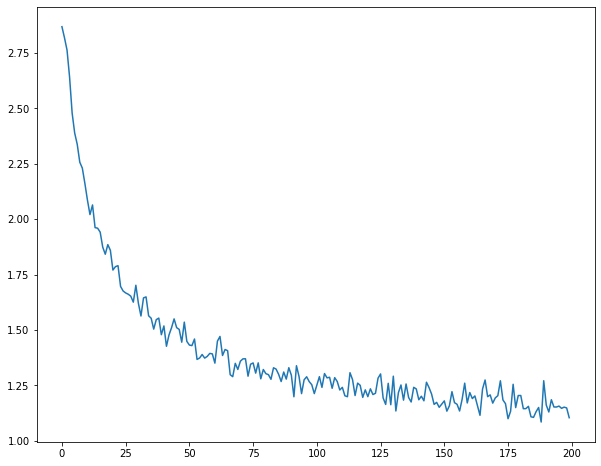

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(all_losses)
plt.show()

In [ ]:
n_predictions = 3 
input_name = "Bukoski"

with torch.no_grad():
    name_tensor = nameToTensor(input_name)
    
    hidden = rnn.initHidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    topv, topi = output.topk(n_predictions, 1, True)
    
    for i in range(n_predictions):
        
        value = topv[0][i].item()
        language_index = topi[0][i].item()
        
        print("(%.2f) %s" % (value, all_languages[language_index]))

(-0.02) Polish
(-4.88) Czech
(-5.13) Russian
